In [1]:
import os
import json
from glob import glob
import numpy as np
import paprika.io as io
import matplotlib.pyplot as plt

import simtk.unit as unit
from simtk.openmm import XmlSerializer, Platform
from simtk.openmm.app import PDBFile, Simulation
from simtk.openmm.openmm import CustomNonbondedForce, LangevinIntegrator, MonteCarloBarostat
from openmmtools.alchemy import AbsoluteAlchemicalFactory, AlchemicalRegion, AlchemicalState

from MDAnalysis.coordinates.DCD import DCDFile

In [2]:
def get_simulation_object(sel1, sel2, system_xml, coordinates, pme_treatment="direct-space"):
    # Setup Alchemical system
    factory = AbsoluteAlchemicalFactory(
        consistent_exceptions=True,
        disable_alchemical_dispersion_correction=False,
        alchemical_pme_treatment=pme_treatment,
        split_alchemical_forces=True,
    )
    alchemical_region = AlchemicalRegion(
        alchemical_atoms=sel1,
        annihilate_electrostatics=True,
        annihilate_sterics=True,
    )
    system_alch = factory.create_alchemical_system(
        system_xml,
        alchemical_region,
    )
    
    # Set Interaction groups
    alchemical_state = AlchemicalState.from_system(system_alch)
    for force in system_alch.getForces():
        if isinstance(force, CustomNonbondedForce):
            force.setInteractionGroupParameters(0, sel1, sel2)
            
    # Create Simulation object
    simulation = Simulation(
        coordinates.topology, 
        system_alch, 
        LangevinIntegrator(298.15, 1.0/unit.picoseconds, 4.0*unit.femtosecond),
        Platform.getPlatformByName('CUDA'),
        {'CudaPrecision': 'mixed'},
    )
    alchemical_state.lambda_sterics = 1.0
    alchemical_state.lambda_electrostatics = 1.0
    alchemical_state.apply_to_context(simulation.context)
    
    return simulation

### Get indices for host and guest molecules

In [3]:
coords = PDBFile("windows/p000/restrained.pdb")

In [4]:
host_resname = "PMQ"
guest_resname = "PG1"
solvent_resname = ["HOH", "Na+", "Cl-"]
host_indices = []
guest_indices = []
solvent_indices = []
for atom in coords.getTopology().atoms():
    if atom.residue.name == host_resname:
        host_indices.append(atom.index)
    if atom.residue.name == guest_resname:
        guest_indices.append(atom.index)
    if atom.residue.name in solvent_resname:
        solvent_indices.append(atom.index)

### Load topology from p000

In [5]:
with open("windows/p000/restrained.xml", "r") as f:
    system = XmlSerializer.deserialize(f.read())

### Generate simulation objects for each pair

In [6]:
pme_treatment = "direct-space"

In [7]:
simulation_hg = get_simulation_object(host_indices, guest_indices, system, coords, pme_treatment)
simulation_hw = get_simulation_object(host_indices, solvent_indices, system, coords, pme_treatment)
simulation_gw = get_simulation_object(guest_indices, solvent_indices, system, coords, pme_treatment)
simulation_hgw = get_simulation_object((host_indices+guest_indices), solvent_indices, system, coords, pme_treatment)

### Get pair nonbonded potential energy 

In [8]:
with open('windows.json', 'r') as f:
    json_data = f.read()
windows = json.loads(json_data, object_hook=io.json_numpy_obj_hook)
windows_list = windows['pull']
n_windows = len(windows_list)

skip_frames = 10

pair_interaction = {
    "host_guest": {"elec": np.zeros(n_windows), "vdw": np.zeros(n_windows), "total": np.zeros(n_windows)},
    "host_solvent": {"elec": np.zeros(n_windows), "vdw": np.zeros(n_windows), "total": np.zeros(n_windows)},
    "guest_solvent": {"elec": np.zeros(n_windows), "vdw": np.zeros(n_windows), "total": np.zeros(n_windows)},
    "host_guest_solvent": {"elec": np.zeros(n_windows), "vdw": np.zeros(n_windows), "total": np.zeros(n_windows)},
}

for i in range(n_windows):
    window = windows_list[i]
    print(f"Analyzing window {window}")
    
    hg_elec = []
    hw_elec = []
    gw_elec = []
    hgw_elec = []
    
    hg_vdw = []
    hw_vdw = []
    gw_vdw = []
    hgw_vdw = []
    
    for trajectory in glob(f"windows/{window}/production-v*.dcd"):
        with DCDFile(trajectory) as dcd:
            header = dcd.header

            for frame in dcd.readframes()[0][::skip_frames]:
                simulation_hg.context.setPositions(frame * unit.angstrom)
                simulation_hw.context.setPositions(frame * unit.angstrom)
                simulation_gw.context.setPositions(frame * unit.angstrom)
                simulation_hgw.context.setPositions(frame * unit.angstrom)

                hg_elec.append(
                    simulation_hg.context.getState(getEnergy=True, groups={1}).getPotentialEnergy() / unit.kilocalorie_per_mole
                )
                hg_vdw.append(
                    simulation_hg.context.getState(getEnergy=True, groups={2}).getPotentialEnergy() / unit.kilocalorie_per_mole
                )
                hw_elec.append(
                    simulation_hw.context.getState(getEnergy=True, groups={1}).getPotentialEnergy() / unit.kilocalorie_per_mole
                )
                hw_vdw.append(
                    simulation_hw.context.getState(getEnergy=True, groups={2}).getPotentialEnergy() / unit.kilocalorie_per_mole
                )
                gw_elec.append(
                    simulation_gw.context.getState(getEnergy=True, groups={1}).getPotentialEnergy() / unit.kilocalorie_per_mole
                )
                gw_vdw.append(
                    simulation_gw.context.getState(getEnergy=True, groups={2}).getPotentialEnergy() / unit.kilocalorie_per_mole
                )
                hgw_elec.append(
                    simulation_hgw.context.getState(getEnergy=True, groups={1}).getPotentialEnergy() / unit.kilocalorie_per_mole
                )
                hgw_vdw.append(
                    simulation_hgw.context.getState(getEnergy=True, groups={2}).getPotentialEnergy() / unit.kilocalorie_per_mole
                )
    
    pair_interaction["host_guest"]["elec"][i] = np.mean(np.array(hg_elec))
    pair_interaction["host_guest"]["vdw"][i] = np.mean(np.array(hg_vdw))
    
    pair_interaction["host_solvent"]["elec"][i] = np.mean(np.array(hw_elec))
    pair_interaction["host_solvent"]["vdw"][i] = np.mean(np.array(hw_vdw))
                                                   
    pair_interaction["guest_solvent"]["elec"][i] = np.mean(np.array(gw_elec))
    pair_interaction["guest_solvent"]["vdw"][i] = np.mean(np.array(gw_vdw))
                                                   
    pair_interaction["host_guest_solvent"]["elec"][i] = np.mean(np.array(hgw_elec))
    pair_interaction["host_guest_solvent"]["vdw"][i] = np.mean(np.array(hgw_vdw))

# Shift energy to zero
for pair in pair_interaction.keys():
    pair_interaction[pair]["elec"] -= pair_interaction[pair]["elec"][-1]
    pair_interaction[pair]["vdw"] -= pair_interaction[pair]["vdw"][-1]
    pair_interaction[pair]["total"] = pair_interaction[pair]["elec"] + pair_interaction[pair]["vdw"]

Analyzing window p000
Analyzing window p001
Analyzing window p002
Analyzing window p003
Analyzing window p004
Analyzing window p005
Analyzing window p006
Analyzing window p007
Analyzing window p008
Analyzing window p009
Analyzing window p010
Analyzing window p011
Analyzing window p012
Analyzing window p013
Analyzing window p014
Analyzing window p015
Analyzing window p016
Analyzing window p017
Analyzing window p018
Analyzing window p019
Analyzing window p020
Analyzing window p021
Analyzing window p022
Analyzing window p023
Analyzing window p024
Analyzing window p025
Analyzing window p026
Analyzing window p027
Analyzing window p028
Analyzing window p029
Analyzing window p030
Analyzing window p031
Analyzing window p032
Analyzing window p033
Analyzing window p034
Analyzing window p035
Analyzing window p036
Analyzing window p037
Analyzing window p038
Analyzing window p039
Analyzing window p040
Analyzing window p041
Analyzing window p042
Analyzing window p043
Analyzing window p044
Analyzing 

## Plot pair-potential profile

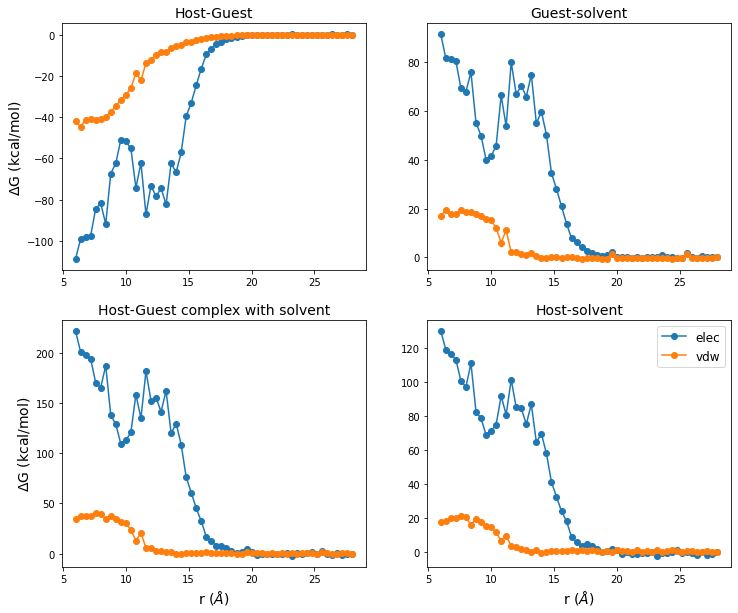

In [9]:
pull_distances = np.linspace(6.0, 28.0, len(windows_list))

plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(pull_distances, pair_interaction["host_guest"]["elec"], 'o-', label="elec")
plt.plot(pull_distances, pair_interaction["host_guest"]["vdw"], 'o-', label="vdw")
plt.ylabel(r"$\Delta$G (kcal/mol)", fontsize=14)
plt.title("Host-Guest", fontsize=14)

plt.subplot(2,2,3)
plt.plot(pull_distances, pair_interaction["host_guest_solvent"]["elec"], 'o-', label="elec")
plt.plot(pull_distances, pair_interaction["host_guest_solvent"]["vdw"], 'o-', label="vdw")
plt.xlabel(r"r ($\AA$)", fontsize=14)
plt.ylabel(r"$\Delta$G (kcal/mol)", fontsize=14)
plt.title("Host-Guest complex with solvent", fontsize=14)

plt.subplot(2,2,2)
plt.plot(pull_distances, pair_interaction["guest_solvent"]["elec"], 'o-', label="elec")
plt.plot(pull_distances, pair_interaction["guest_solvent"]["vdw"], 'o-', label="vdw")
plt.title("Guest-solvent", fontsize=14)

plt.subplot(2,2,4)
plt.plot(pull_distances, pair_interaction["host_solvent"]["elec"], 'o-', label="elec")
plt.plot(pull_distances, pair_interaction["host_solvent"]["vdw"], 'o-', label="vdw")
plt.xlabel(r"r ($\AA$)", fontsize=14)
plt.title("Host-solvent", fontsize=14)

plt.legend(fontsize=12)